## SVD

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.sparse
import sklearn.manifold

import time
from underrate import *

## load data

In [2]:
dRatings = loadRatings("data/data.txt")
dTrain = loadRatings("data/train.txt", dRatings.shape)
dTest = loadRatings("data/test.txt", dRatings.shape)

dUsers = pd.DataFrame(index=dRatings.index)
dMovies, dGenres = loadMovies("data/movies.txt")

nUsers = dUsers.shape[0]
nRatings = dRatings.shape[0]
nMovies = dMovies.shape[0]
nGenres = dGenres.shape[1]

In [3]:
stats = ratingStats(dRatings)
dMovies = pd.concat([dMovies, stats[1]], axis=1)
dUsers = pd.concat([dUsers, stats[0]], axis=1)

## training

In [4]:
def grad_U(Ui, Yij, Vj, reg):
    """
    Returns the gradient of the regularized loss function with
    respect to Ui.
    """
    return reg * Ui - Vj * (Yij - np.dot(Ui, Vj))

def grad_V(Vj, Yij, Ui, reg):
    """
    Returns the gradient of the regularized loss function with
    respect to Vj multiplied by eta.
    """
    return reg * Vj - Ui * (Yij - np.dot(Ui, Vj))

def get_err(U, V, ratings, reg=0.0, N=None):
    """
    Returns the mean regularized squared-error of predictions made by
    estimating Y_{ij} as the dot product of the ith row of U and the jth column of V^T.
    """
    N = N if N else (~np.isnan(dRatings.values)).sum()
    r = .5 * reg / N * (np.sum(np.square(U)) + np.sum(np.square(V))) if reg else 0
    return np.nanmean(np.square(ratings.values - np.matmul(U, V.T)))

def train_model(ratings, K, eta, reg, eps=0.0001, max_epochs=300):
    """
    Returns a tuple (U, V, err) consisting of U, V, and the unregularized MSEs
    of the model.
    """
    n_users, n_movies = ratings.shape
    users_i, movies_i = (~np.isnan(ratings.values)).nonzero()
    n_ratings = len(users_i)
    ratings_ = ratings.values
    U = np.random.rand(n_users, K) - 0.5
    V = np.random.rand(n_movies, K) - 0.5
    eprev = get_err(U, V, ratings)
    reduction0 = 1
    for epoch in range(max_epochs):
        for i in np.random.permutation(n_ratings):
            user, movie = users_i[i], movies_i[i]
            rating = ratings_[user, movie]
            # calculate gradients at once
            gU = grad_U(U[user], rating, V[movie], reg)
            gV = grad_V(V[movie], rating, U[user], reg)
            # before descending
            U[user] -= eta * gU
            V[movie] -= eta * gV
        e = get_err(U, V, ratings)
        # stopping conditions
        reduction = eprev - e
        reductionratio = reduction / reduction0
        print("epoch", epoch, eprev, reductionratio)
        if (epoch == 0):
            reduction0 = reduction
        if (reductionratio < eps):
            break
        eprev = e
    print("trained epochs:", epoch, reduction)
    return U, V, e

## 2D:
Run the cell below to get your graphs

K 120
epoch 0 14.569940244514376 13.786809569151428
epoch 1 0.7831306753629474 0.02356588083062782
epoch 2 0.4582323640217656 0.006020400449073795
epoch 3 0.37523024950035144 0.003622348990533501
epoch 4 0.32528961377485816 0.0026761807940816353
epoch 5 0.2883936187942342 0.0015349599397124053
epoch 6 0.2672314184091431 0.0015970975105329553
epoch 7 0.24521253916805943 0.0009704664613111114
epoch 8 0.23183290287271488 0.0006939871751435542
epoch 9 0.22226503384557736 0.000678218465497792
epoch 10 0.2129145650154772 0.0007012672353531664
epoch 11 0.2032463271845778 0.00019713203941526967
epoch 12 0.20052850529718103 0.0006934690380928489
epoch 13 0.1909677797268923 0.00033749092656951574
epoch 14 0.18631485659096192 0.0002614167735325384
epoch 15 0.18271075331608683 0.00015279327872411722
epoch 16 0.18060422147887115 0.00028018260390981156
epoch 17 0.1767413972741776 4.6392334386541914e-06
trained epochs: 17 6.396022796556489e-05
elapsed 34.469510316848755


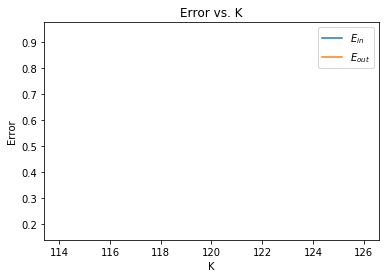

In [5]:
Ks = [120]

reg = 0.05
eta = 0.03 # learning rate
E_in = []
E_out = []
Us = []
Vs = []

# Use to compute Ein and Eout
start = time.time()
for K in Ks:
    print("K", K)
    U,V, err = train_model(dTrain, K, eta, reg)
    E_in.append(err)
    E_out.append(get_err(U, V, dTest))
    Us.append(U)
    Vs.append(V)
print("elapsed", time.time() - start)

plt.plot(Ks, E_in, label='$E_{in}$')
plt.plot(Ks, E_out, label='$E_{out}$')
plt.title('Error vs. K')
plt.xlabel('K')
plt.ylabel('Error')
plt.legend()

In [6]:
tsneMovies = sklearn.manifold.TSNE(n_components=2).fit_transform(Vs[0])
print(tsneMovies.shape)

(1682, 2)


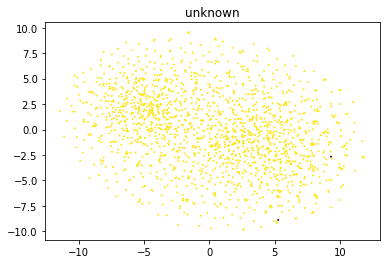

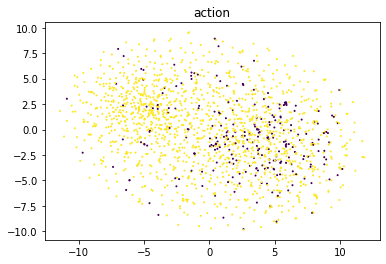

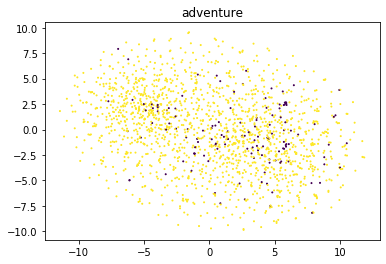

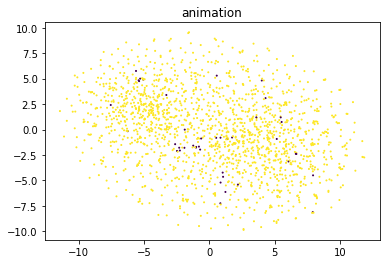

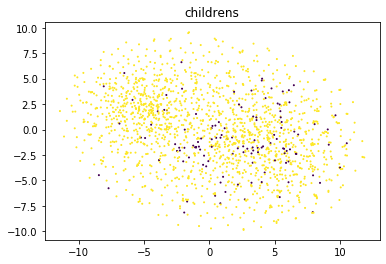

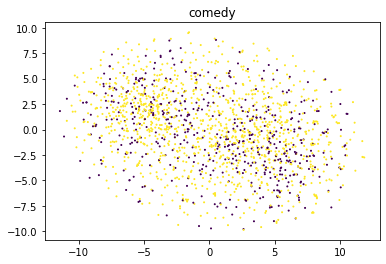

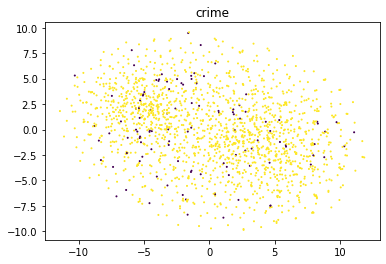

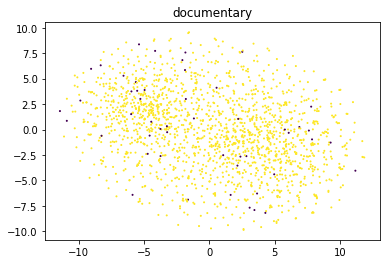

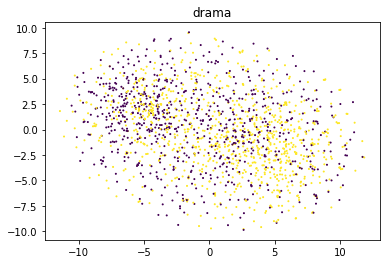

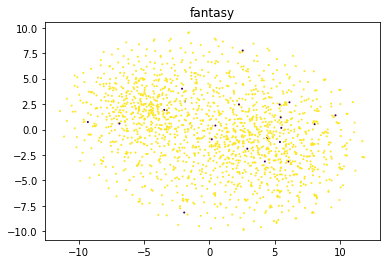

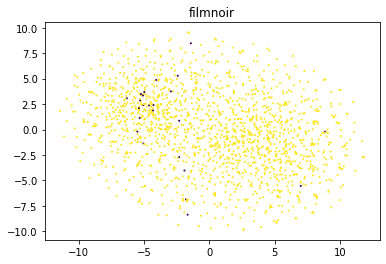

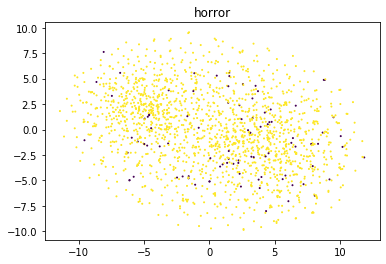

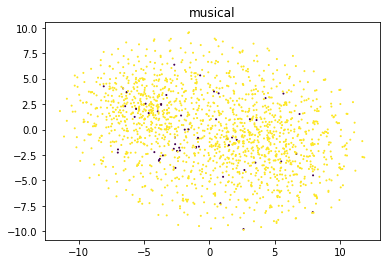

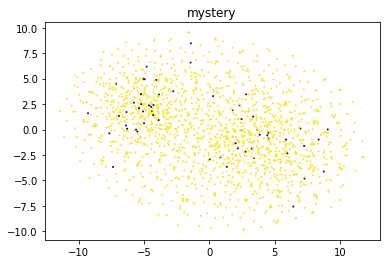

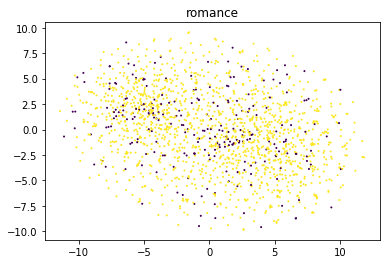

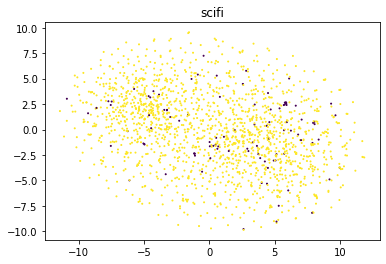

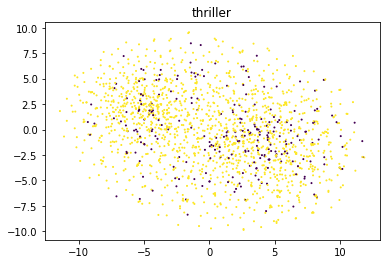

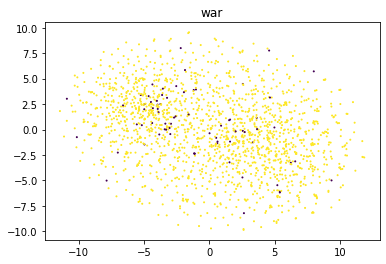

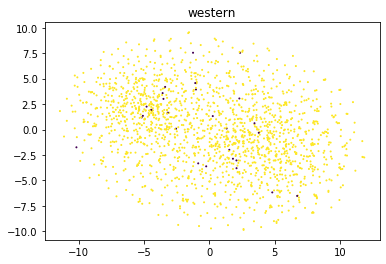

In [7]:
for i in range(19):
    plt.figure()
    plt.title(dGenres.columns[i])
    plt.scatter(tsneMovies[:,0], tsneMovies[:,1], s=1, c=-dGenres.iloc[:,i])

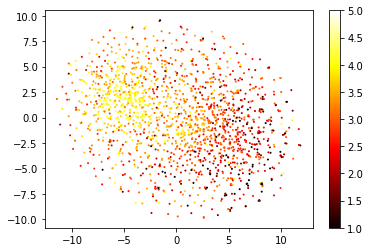

In [8]:
plt.scatter(tsneMovies[:,0], tsneMovies[:,1], s=1, c=dMovies["movieavg"], cmap="hot")
plt.colorbar()